In [35]:

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout,RepeatVector,TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [36]:
#Read the csv file
df = pd.read_csv('GE.csv')
print(df.head()) #7 columns, including the Date. 

         Date        Open        High         Low       Close   Adj Close  \
0  2021-09-07  104.500000  104.940002  102.309998  103.290001  102.904030   
1  2021-09-08  102.949997  104.730003  100.419998  102.580002  102.196693   
2  2021-09-09  102.360001  104.919998  102.110001  103.290001  102.904030   
3  2021-09-10  103.290001  103.949997  101.779999  102.000000  101.618858   
4  2021-09-13  102.650002  104.860001  102.019997  104.459999  104.069664   

     Volume  
0  10989500  
1  12001300  
2   9386500  
3   9563600  
4  12484200  


In [37]:
#Separate dates for future plotting as this is not our one of the feature we are just using to plot our daat
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates.

236   2022-08-15
237   2022-08-16
238   2022-08-17
239   2022-08-18
240   2022-08-19
241   2022-08-22
242   2022-08-23
243   2022-08-24
244   2022-08-25
245   2022-08-26
246   2022-08-29
247   2022-08-30
248   2022-08-31
249   2022-09-01
250   2022-09-02
Name: Date, dtype: datetime64[ns]


In [38]:
#Variables for training which we want to use
cols = list(df)[1:6]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

['Open', 'High', 'Low', 'Close', 'Adj Close']


In [39]:

#New dataframe with only training data - 5 columns because when we do normalisation then we dont loose our normalisation
df_for_training = df[cols].astype(float)

In [40]:
df_for_training

,Open,High,Low,Close,Adj Close
0,104.500000,104.940002,102.309998,103.290001,102.904030
1,102.949997,104.730003,100.419998,102.580002,102.196693
2,102.360001,104.919998,102.110001,103.290001,102.904030
3,103.290001,103.949997,101.779999,102.000000,101.618858
4,102.650002,104.860001,102.019997,104.459999,104.069664
...,...,...,...,...,...
246,74.839996,76.839996,74.279999,76.050003,76.050003
247,76.760002,77.180000,74.330002,75.129997,75.129997
248,75.410004,75.790001,73.360001,73.440002,73.440002
249,73.250000,73.250000,71.430000,73.080002,73.080002


In [56]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [57]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.


In [58]:
#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

In [59]:

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (237, 14, 5).
trainY shape == (237, 1).


In [60]:
# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 14, 64)            17920     
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [61]:
# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)


Train on 213 samples, validate on 24 samples
Epoch 1/5
213/213 [==============================] - 3s 15ms/sample - loss: 0.5141 - val_loss: 0.1617
Epoch 2/5
213/213 [==============================] - 1s 3ms/sample - loss: 0.2110 - val_loss: 0.1876
Epoch 3/5
213/213 [==============================] - 1s 3ms/sample - loss: 0.1756 - val_loss: 0.0583
Epoch 4/5
213/213 [==============================] - 1s 3ms/sample - loss: 0.1156 - val_loss: 0.0392
Epoch 5/5
213/213 [==============================] - 1s 3ms/sample - loss: 0.0869 - val_loss: 0.0386


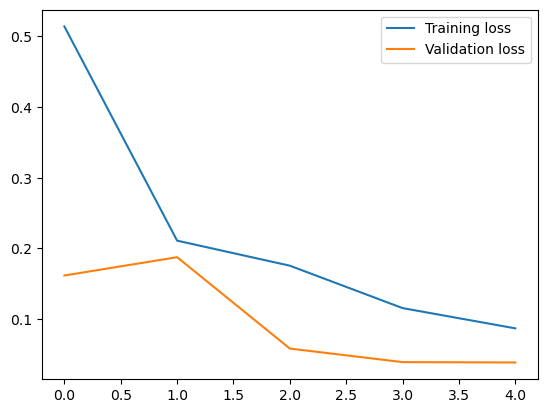

In [62]:

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


In [67]:
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [68]:
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

[Timestamp('2022-08-12 00:00:00', freq='C'), Timestamp('2022-08-15 00:00:00', freq='C'), Timestamp('2022-08-16 00:00:00', freq='C'), Timestamp('2022-08-17 00:00:00', freq='C'), Timestamp('2022-08-18 00:00:00', freq='C'), Timestamp('2022-08-19 00:00:00', freq='C'), Timestamp('2022-08-22 00:00:00', freq='C'), Timestamp('2022-08-23 00:00:00', freq='C'), Timestamp('2022-08-24 00:00:00', freq='C'), Timestamp('2022-08-25 00:00:00', freq='C'), Timestamp('2022-08-26 00:00:00', freq='C'), Timestamp('2022-08-29 00:00:00', freq='C'), Timestamp('2022-08-30 00:00:00', freq='C'), Timestamp('2022-08-31 00:00:00', freq='C'), Timestamp('2022-09-01 00:00:00', freq='C')]


In [69]:
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

In [71]:
prediction.shape
# these are our scaled values now we waant our stock value back

(15, 1)

In [72]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
# basically df_for_trainnig means :-5 as here are just 1 feature but when we standardised it we had 5 features so we are copying


In [73]:
y_pred_future
# these are our actual predicted stock values

array([76.089264, 76.74185 , 77.39806 , 77.91508 , 78.31858 , 78.51858 ,
       78.413445, 78.23709 , 78.09144 , 78.081375, 77.97138 , 77.79754 ,
       77.57594 , 77.21041 , 76.696815], dtype=float32)

In [74]:

# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [75]:
df_forecast

,Date,Open
0,2022-08-12,76.089264
1,2022-08-15,76.741852
2,2022-08-16,77.398064
3,2022-08-17,77.915077
4,2022-08-18,78.318581
5,2022-08-19,78.518578
6,2022-08-22,78.413445
7,2022-08-23,78.237091
8,2022-08-24,78.091438
9,2022-08-25,78.081375


In [92]:

original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2022-5-1']

/Users/muskanchoudhary/opt/anaconda3/envs/tf1/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/Users/muskanchoudhary/opt/anaconda3/envs/tf1/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/muskanchoudhary/opt/anaconda3/envs/tf1/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Date', ylabel='Open'>

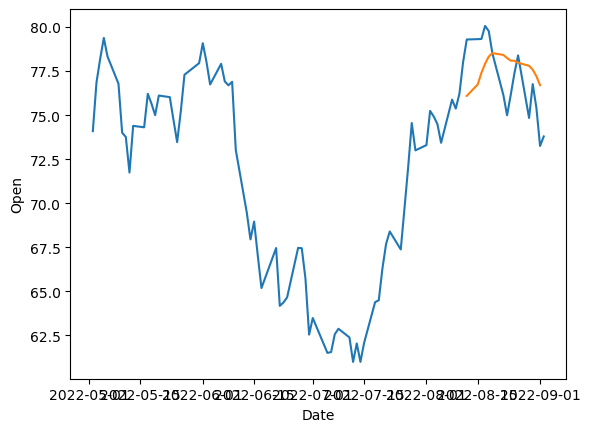

In [93]:
sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])
